In [4]:
from dotenv import load_dotenv
import os
import snowflake.connector
import pandas as pd
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

c:\Users\SwarnadeepPramanik\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()


True

## Connection with snowflake and  get all tables

In [127]:


try:
    # Connect to Snowflake using environment variables
    snowflake_conn = snowflake.connector.connect(
        user=os.environ["SNOWFLAKE_USER"],
        password=os.environ["SNOWFLAKE_PASSWORD"],
        account=os.environ["SNOWFLAKE_ACCOUNT"],
        warehouse=os.environ["SNOWFLAKE_WAREHOUSE"],
        database=os.environ["SNOWFLAKE_DATABASE"],
        schema=os.environ["SNOWFLAKE_SCHEMA"],
        role=os.environ["SNOWFLAKE_ROLE"]
    )

    # Create raw_data folder if it doesn't exist
    if not os.path.exists("staging_raw_data"):
        os.makedirs("staging_raw_data")

    # Get a cursor
    cursor = snowflake_conn.cursor()

    # Get a list of all tables in the schema
    cursor.execute("SHOW TABLES")
    tables = [table[1] for table in cursor.fetchall()]


   # Loop through each table
    for table_name in tables:
        # Construct the query to select all data from the table
        query = f"SELECT * FROM {table_name}"

        # Execute the query
        cursor.execute(query)

        # Fetch all rows
        rows = cursor.fetchall()
        
       
        # Convert rows to pandas DataFrame
        df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
        
        # Define the path to save the CSV file
        csv_file_path = os.path.join("staging_raw_data", f"{table_name}.csv")

        # Write data to CSV file
        df.to_csv(csv_file_path, index=False)

        print(f"Table '{table_name}' exported to '{csv_file_path}' successfully!")

    # Close cursor
    cursor.close()

    # Close connection
    snowflake_conn.close()

except snowflake.connector.errors.DatabaseError as e:
    # Print connection failure message
    print(f"Failed to connect to Snowflake: {e}")


Table 'TBL_APPROVER_USER' exported to 'staging_raw_data\TBL_APPROVER_USER.csv' successfully!
Table 'TBL_CERTIFICATES' exported to 'staging_raw_data\TBL_CERTIFICATES.csv' successfully!
Table 'TBL_SKILLS' exported to 'staging_raw_data\TBL_SKILLS.csv' successfully!
Table 'TBL_USER' exported to 'staging_raw_data\TBL_USER.csv' successfully!
Table 'TBL_USER_CERTIFICATE' exported to 'staging_raw_data\TBL_USER_CERTIFICATE.csv' successfully!
Table 'TBL_USER_PROJECT' exported to 'staging_raw_data\TBL_USER_PROJECT.csv' successfully!
Table 'TBL_USER_SKILL' exported to 'staging_raw_data\TBL_USER_SKILL.csv' successfully!


In [3]:
os.listdir('staging_raw_data/')

['TBL_APPROVER_USER.csv',
 'TBL_CERTIFICATES.csv',
 'TBL_SKILLS.csv',
 'TBL_USER.csv',
 'TBL_USER_CERTIFICATE.csv',
 'TBL_USER_PROJECT.csv',
 'TBL_USER_SKILL.csv']

#### Create skillsDetails

In [4]:
# Read 'TBL_SKILLS' CSV
skills_df = pd.read_csv(os.path.join("staging_raw_data", "TBL_SKILLS.csv"))

# Read 'TBL_USER_SKILL' CSV
user_skills_df = pd.read_csv(os.path.join("staging_raw_data", "TBL_USER_SKILL.csv"))

# Merge dataframes on 'SKILL_ID'
merged_df = pd.merge(user_skills_df,skills_df,  on='SKILL_ID', how='left')

 # Rename the 'ID' column to 'USER_SKILL_ID'
merged_df.rename(columns={'ID': 'USER_SKILL_ID'}, inplace=True)

# Read 'TBL_USER.csv'
user_df = pd.read_csv(os.path.join("staging_raw_data", "TBL_USER.csv"))

# Perform left join with 'TBL_USER.csv' DataFrame
skillsDetails_df = pd.merge(merged_df, user_df, on='USER_ID', how='left')



print(skillsDetails_df.columns)

Index(['USER_SKILL_ID', 'SKILL_ID', 'USER_ID', 'SKILL_LEVEL', 'STATUS',
       'SKILL_NAME', 'EMAIL', 'FIRST_NAME', 'LAST_NAME', 'ROLE',
       'PHONE_NUMBER', 'PASSWORD', 'CHANGE_PASSWORD'],
      dtype='object')


#### Craete certificateDetails

In [5]:
# Read 'TBL_USER_CERTIFICATE' CSV
user_certificate_df = pd.read_csv(os.path.join("staging_raw_data", "TBL_USER_CERTIFICATE.csv"))

# Read 'TBL_CERTIFICATES' CSV
certificates_df = pd.read_csv(os.path.join("staging_raw_data", "TBL_CERTIFICATES.csv"))

# Merge dataframes on 'CERTIFICATE_ID'
merged_df = pd.merge(user_certificate_df, certificates_df, on='CERTIFICATE_ID', how='left')



# Perform left join with 'TBL_USER.csv' DataFrame
certificateDetails_df = pd.merge(merged_df, user_df, on='USER_ID', how='left')

# Rename the 'ID' column to 'USER_CERTIFICATE_ID'
certificateDetails_df.rename(columns={'ID': 'USER_CERTIFICATE_ID'}, inplace=True)
print(certificateDetails_df.columns)


Index(['USER_CERTIFICATE_ID', 'CERTIFICATE_ID', 'USER_ID', 'VALID_FROM',
       'VALID_TILL', 'STATUS', 'CREDENTIAL_ID', 'CERTIFICATE_NAME', 'EMAIL',
       'FIRST_NAME', 'LAST_NAME', 'ROLE', 'PHONE_NUMBER', 'PASSWORD',
       'CHANGE_PASSWORD'],
      dtype='object')


#### Create projectDetails

In [6]:
# Read 'TBL_USER_CERTIFICATE' CSV
user_project_df = pd.read_csv(os.path.join("staging_raw_data", "TBL_USER_PROJECT.csv"))

# Perform left join with 'TBL_USER.csv' DataFrame
projectDetails_df = pd.merge(user_project_df, user_df, on='USER_ID', how='left')

# Rename the 'ID' column to 'USER_CERTIFICATE_ID'
projectDetails_df.rename(columns={'ID': 'USER_PROJECT_ID'}, inplace=True)
print(projectDetails_df.columns)


Index(['USER_PROJECT_ID', 'USER_ID', 'PROJECT_NAME', 'PROJECT_DESCRIPTION',
       'STATUS', 'PROJECT_LINK', 'EMAIL', 'FIRST_NAME', 'LAST_NAME', 'ROLE',
       'PHONE_NUMBER', 'PASSWORD', 'CHANGE_PASSWORD'],
      dtype='object')


# EDA & Features Selection
## for all three df

In [7]:
# Merge 'FIRST_NAME' and 'LAST_NAME' into 'FULL_NAME'
skillsDetails_df['FULL_NAME'] = skillsDetails_df['FIRST_NAME'] + ' ' + skillsDetails_df['LAST_NAME']

# Drop 'FIRST_NAME' and 'LAST_NAME' columns
skillsDetails_df.drop(['FIRST_NAME', 'LAST_NAME'], axis=1, inplace=True)

skillsDetails_df.describe()


,USER_SKILL_ID,SKILL_ID,USER_ID,PHONE_NUMBER
count,1042.000000,1042.000000,1042.000000,1.042000e+03
mean,556.350288,25.491363,250.718810,5.832906e+09
std,319.270932,14.426348,144.117376,2.630287e+09
min,1.000000,1.000000,11.000000,1.004939e+09
25%,278.250000,13.000000,126.250000,3.605239e+09
50%,561.500000,26.000000,245.000000,5.924298e+09
75%,833.750000,38.000000,379.000000,8.247059e+09
max,1100.000000,50.000000,510.000000,9.996021e+09


In [8]:
skillsDetails_df.nunique()

USER_SKILL_ID      1042
SKILL_ID             50
USER_ID             386
SKILL_LEVEL           3
STATUS                3
SKILL_NAME           49
EMAIL               386
ROLE                  2
PHONE_NUMBER        386
PASSWORD            386
CHANGE_PASSWORD       1
FULL_NAME           386
dtype: int64

In [9]:
skillsDetails_df.shape

(1042, 12)

In [10]:
skillsDetails_df.isnull().sum()

USER_SKILL_ID      0
SKILL_ID           0
USER_ID            0
SKILL_LEVEL        0
STATUS             0
SKILL_NAME         0
EMAIL              0
ROLE               0
PHONE_NUMBER       0
PASSWORD           0
CHANGE_PASSWORD    0
FULL_NAME          0
dtype: int64

In [12]:
skillsDetails_df.shape , certificateDetails_df.shape , projectDetails_df.shape

((1042, 12), (942, 15), (1110, 13))

In [13]:
m1_temp = pd.merge(skillsDetails_df,projectDetails_df,on="USER_ID",how="left")


m2_temp = pd.merge(m1_temp,certificateDetails_df,on='USER_ID',how='left')

In [15]:
m2_temp.to_csv("raw.csv",index=None)

In [17]:
profile = ProfileReport(m2_temp,title="Auto EDA Report")

In [18]:
profile.to_file('eda.html')

Summarize dataset:  89%|████████▉ | 40/45 [00:02<00:00, 24.50it/s, Calculate auto correlation]           c:\Users\Swarna\AppData\Local\Programs\Python\Python310\lib\site-packages\ydata_profiling\model\correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'AWS Certified Security - Specialty'')
  warnings.warn(
Summarize dataset:  96%|█████████▌| 124/129 [00:13<00:01,  4.34it/s, Missing diagram heatmap]                         c:\Users\Swarna\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different beh

In [136]:
skillsDetails_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   USER_SKILL_ID    1042 non-null   int64 
 1   SKILL_ID         1042 non-null   int64 
 2   USER_ID          1042 non-null   int64 
 3   SKILL_LEVEL      1042 non-null   object
 4   STATUS           1042 non-null   object
 5   SKILL_NAME       1042 non-null   object
 6   EMAIL            1042 non-null   object
 7   ROLE             1042 non-null   object
 8   PHONE_NUMBER     1042 non-null   int64 
 9   PASSWORD         1042 non-null   object
 10  CHANGE_PASSWORD  1042 non-null   bool  
 11  FULL_NAME        1042 non-null   object
dtypes: bool(1), int64(4), object(7)
memory usage: 90.7+ KB


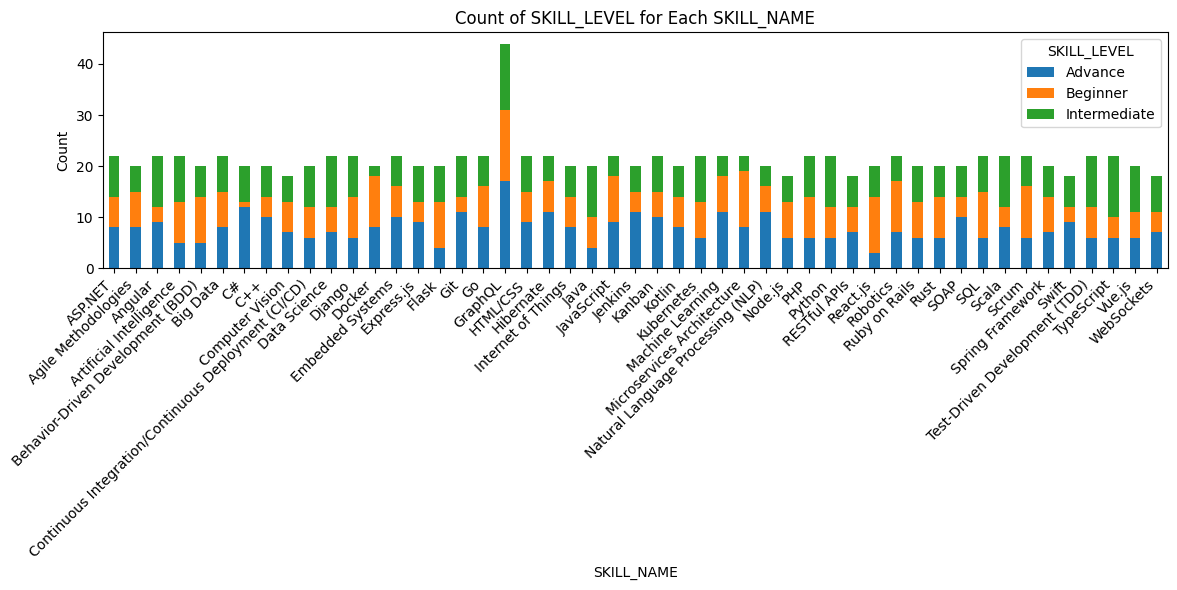

In [137]:


# Group data by 'SKILL_NAME' and 'SKILL_LEVEL', and count occurrences
skill_level_counts = skillsDetails_df.groupby(['SKILL_NAME', 'SKILL_LEVEL']).size().unstack(fill_value=0)

# Plot the bar chart
skill_level_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('SKILL_NAME')
plt.ylabel('Count')
plt.title('Count of SKILL_LEVEL for Each SKILL_NAME')
plt.xticks(rotation=45, ha='right')
plt.legend(title='SKILL_LEVEL')
plt.tight_layout()
plt.show()


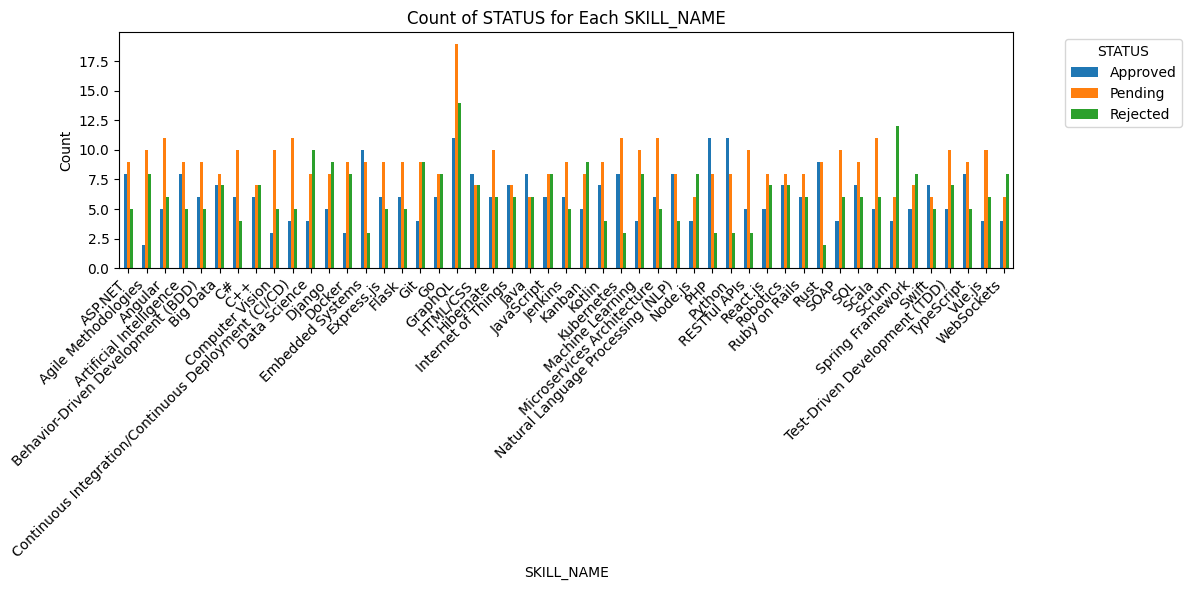

In [138]:
import matplotlib.pyplot as plt

# Group data by 'SKILL_NAME' and 'STATUS', and count occurrences
status_counts = skillsDetails_df.groupby(['SKILL_NAME', 'STATUS']).size().unstack(fill_value=0)

# Plot the bar chart
status_counts.plot(kind='bar', figsize=(12, 6))
plt.xlabel('SKILL_NAME')
plt.ylabel('Count')
plt.title('Count of STATUS for Each SKILL_NAME')
plt.xticks(rotation=45, ha='right')
plt.legend(title='STATUS', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [139]:

# Display the filtered data
# Filter the data where STATUS is 'Approved'
skillsDetails_df = skillsDetails_df[skillsDetails_df['STATUS'] == 'Approved']

# Select specific columns
skillsDetails_df = skillsDetails_df[['USER_ID','FULL_NAME','SKILL_NAME','SKILL_LEVEL']]

# Display the filtered data
skillsDetails_df



,USER_ID,FULL_NAME,SKILL_NAME,SKILL_LEVEL
0,169,Maximo McCauley,Kanban,Advance
1,158,Kania Haggus,Artificial Intelligence,Beginner
2,299,Taite Tipping,Java,Intermediate
6,362,Nigel Lewing,TypeScript,Beginner
7,149,Christiane Sharer,Vue.js,Beginner
...,...,...,...,...
743,68,Clem Latan,Jenkins,Beginner
744,424,Loydie Wych,HTML/CSS,Intermediate
745,509,Karen Seckington,Ruby on Rails,Intermediate
746,179,Swen Yarrington,Continuous Integration/Continuous Deployment (...,Intermediate


In [140]:
certificateDetails_df.describe()

,USER_CERTIFICATE_ID,CERTIFICATE_ID,USER_ID,PHONE_NUMBER
count,942.000000,942.000000,942.000000,9.420000e+02
mean,505.023355,25.332272,249.445860,5.855716e+09
std,288.827380,14.462271,144.951656,2.621700e+09
min,2.000000,1.000000,11.000000,1.004939e+09
25%,255.250000,13.000000,127.000000,3.653831e+09
50%,508.500000,25.000000,239.500000,5.945981e+09
75%,756.750000,38.000000,377.000000,8.247059e+09
max,1000.000000,50.000000,510.000000,9.996021e+09


In [141]:
certificateDetails_df.nunique()

USER_CERTIFICATE_ID    942
CERTIFICATE_ID          50
USER_ID                377
VALID_FROM             338
VALID_TILL             337
STATUS                   3
CREDENTIAL_ID          942
CERTIFICATE_NAME        50
EMAIL                  377
FIRST_NAME             367
LAST_NAME              376
ROLE                     2
PHONE_NUMBER           377
PASSWORD               377
CHANGE_PASSWORD          1
dtype: int64

In [142]:
certificateDetails_df.shape

(942, 15)

In [143]:
certificateDetails_df.isnull().sum()

USER_CERTIFICATE_ID    0
CERTIFICATE_ID         0
USER_ID                0
VALID_FROM             0
VALID_TILL             0
STATUS                 0
CREDENTIAL_ID          0
CERTIFICATE_NAME       0
EMAIL                  0
FIRST_NAME             0
LAST_NAME              0
ROLE                   0
PHONE_NUMBER           0
PASSWORD               0
CHANGE_PASSWORD        0
dtype: int64

In [144]:
certificateDetails_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   USER_CERTIFICATE_ID  942 non-null    int64 
 1   CERTIFICATE_ID       942 non-null    int64 
 2   USER_ID              942 non-null    int64 
 3   VALID_FROM           942 non-null    object
 4   VALID_TILL           942 non-null    object
 5   STATUS               942 non-null    object
 6   CREDENTIAL_ID        942 non-null    object
 7   CERTIFICATE_NAME     942 non-null    object
 8   EMAIL                942 non-null    object
 9   FIRST_NAME           942 non-null    object
 10  LAST_NAME            942 non-null    object
 11  ROLE                 942 non-null    object
 12  PHONE_NUMBER         942 non-null    int64 
 13  PASSWORD             942 non-null    object
 14  CHANGE_PASSWORD      942 non-null    bool  
dtypes: bool(1), int64(4), object(10)
memory usage: 104.1+ KB


In [145]:
certificateDetails_df

,USER_CERTIFICATE_ID,CERTIFICATE_ID,USER_ID,VALID_FROM,VALID_TILL,STATUS,CREDENTIAL_ID,CERTIFICATE_NAME,EMAIL,FIRST_NAME,LAST_NAME,ROLE,PHONE_NUMBER,PASSWORD,CHANGE_PASSWORD
0,2,1,365,2023-08-08,2025-08-08,Approved,e82e1710-6bc6-4079-a251-68a66e5ffd73,AWS Certified Solutions Architect - Associate,tgreatreax9u@netscape.com,Terri,Greatreax,user,2849653230,kK1%VP5Z?pDN&,True
1,3,2,141,2023-09-14,2025-09-14,Rejected,9e2b7197-7aa7-4220-bd00-485c12a20815,AWS Certified Developer - Associate,striplet3m@hp.com,Sonya,Triplet,user,8728493974,mG9'Op`/NHs,True
2,4,14,73,2023-05-03,2025-05-03,Approved,e52cc688-a353-47a9-b746-33f7a9bc8fe2,Google Professional Collaboration Engineer,cbywaters1q@4shared.com,Carly,Bywaters,user,1521740095,nC6'Q&>G=k8$)4=6,True
3,5,12,216,2023-11-24,2025-11-24,Approved,8966136d-1724-4d13-a2d5-55cd88d5f96e,Google Professional Cloud Network Engineer,ishorie5p@ftc.gov,Isis,Shorie,user,6103258438,sX8|eo'#?,True
4,6,31,234,2024-02-24,2026-02-24,Rejected,03d910eb-da21-44a1-978a-a5c6e6b11797,Cisco Certified Network Associate (CCNA),agarvill67@nifty.com,Ajay,Garvill,user,1308058548,"hU9>noA~SW,!&4|",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,996,41,451,2023-08-28,2025-08-28,Pending,078c80b8-816f-400b-b2e3-bac65b3da34e,Certified Information Systems Auditor (CISA),afitzsimonc8@disqus.com,Angel,Fitzsimon,user,1236955403,"eV2=\jE!Q""k#L~}E",True
938,997,16,252,2024-02-27,2026-02-27,Pending,0fcdb28a-bbff-4fed-a542-8976f87f445c,Microsoft Certified: Azure Fundamentals,cguillond6p@time.com,Carolina,Guillond,user,8999801337,"bN7#IHr9""Wo$",True
939,998,4,391,2024-01-26,2026-01-26,Pending,f2300e88-1cb0-45ca-b041-eea5759149ff,AWS Certified Solutions Architect - Professional,carthargak@stanford.edu,Clementia,Artharg,user,9109717550,bX3@>=06ABhkN,True
940,999,6,150,2023-05-04,2025-05-04,Pending,c4ce8497-9c99-427a-bda3-dd8835c3aaf0,AWS Certified Security - Specialty,dbignell3v@altervista.org,Dorothee,Bignell,user,1457066137,mQ4*GC`@w6!,True


In [146]:
certificateDetails_df['FULL_NAME'] = certificateDetails_df['FIRST_NAME'] + ' ' + certificateDetails_df['LAST_NAME']

# Drop 'FIRST_NAME' and 'LAST_NAME' columns
certificateDetails_df.drop(['FIRST_NAME', 'LAST_NAME'], axis=1, inplace=True)

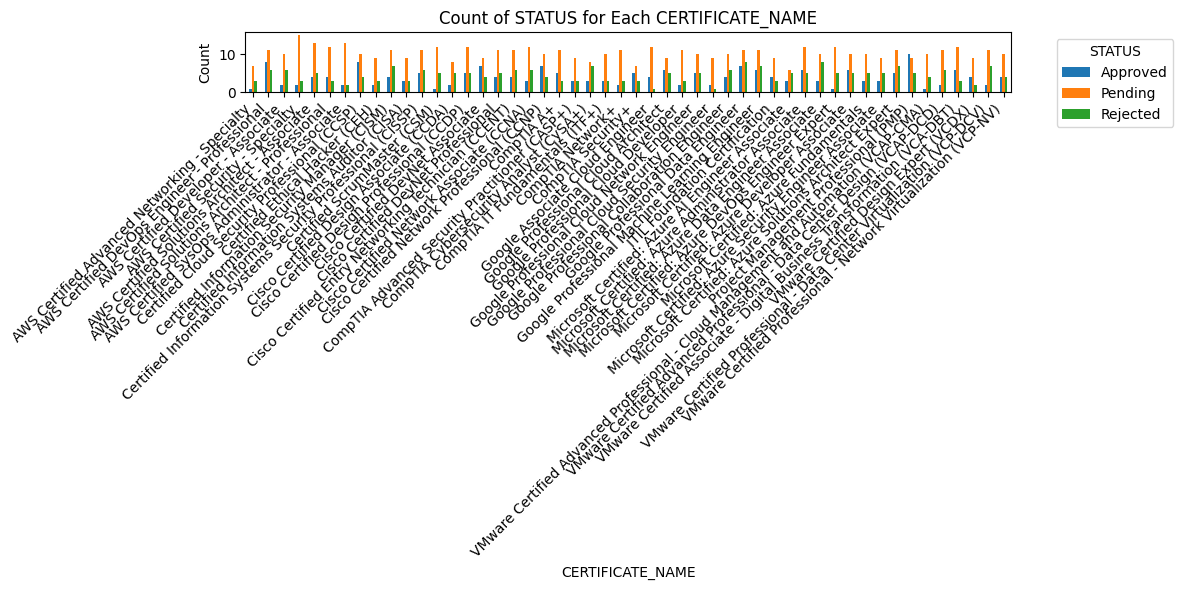

In [147]:
import matplotlib.pyplot as plt

# Group data by 'CERTIFICATE_NAME' and 'STATUS', and count occurrences
status_counts = certificateDetails_df.groupby(['CERTIFICATE_NAME', 'STATUS']).size().unstack(fill_value=0)

# Plot the bar chart
status_counts.plot(kind='bar', figsize=(12, 6))
plt.xlabel('CERTIFICATE_NAME')
plt.ylabel('Count')
plt.title('Count of STATUS for Each CERTIFICATE_NAME')
plt.xticks(rotation=45, ha='right')
plt.legend(title='STATUS', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



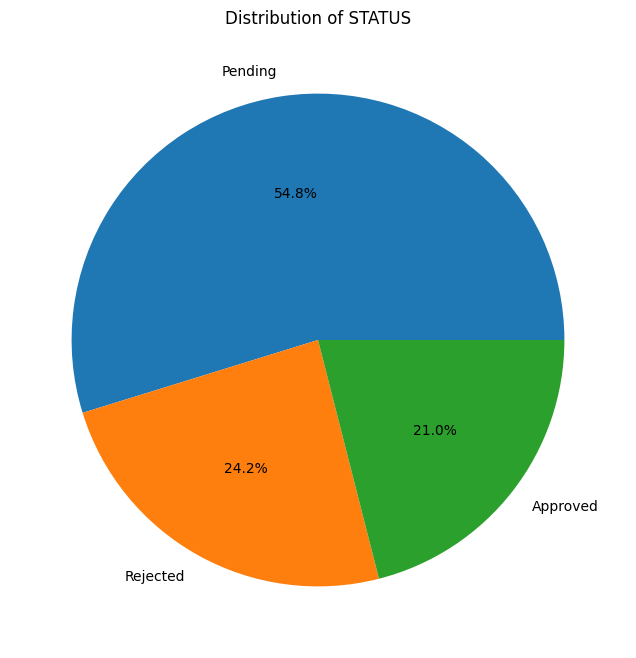

In [148]:
import matplotlib.pyplot as plt

# Count occurrences of each 'STATUS' category
status_counts = certificateDetails_df['STATUS'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%')
plt.title('Distribution of STATUS')
plt.show()


In [149]:
# Filter the data where STATUS is 'Approved'
certificateDetails_df = certificateDetails_df[certificateDetails_df['STATUS'] == 'Approved']

# Display the filtered data
certificateDetails_df


,USER_CERTIFICATE_ID,CERTIFICATE_ID,USER_ID,VALID_FROM,VALID_TILL,STATUS,CREDENTIAL_ID,CERTIFICATE_NAME,EMAIL,ROLE,PHONE_NUMBER,PASSWORD,CHANGE_PASSWORD,FULL_NAME
0,2,1,365,2023-08-08,2025-08-08,Approved,e82e1710-6bc6-4079-a251-68a66e5ffd73,AWS Certified Solutions Architect - Associate,tgreatreax9u@netscape.com,user,2849653230,kK1%VP5Z?pDN&,True,Terri Greatreax
2,4,14,73,2023-05-03,2025-05-03,Approved,e52cc688-a353-47a9-b746-33f7a9bc8fe2,Google Professional Collaboration Engineer,cbywaters1q@4shared.com,user,1521740095,nC6'Q&>G=k8$)4=6,True,Carly Bywaters
3,5,12,216,2023-11-24,2025-11-24,Approved,8966136d-1724-4d13-a2d5-55cd88d5f96e,Google Professional Cloud Network Engineer,ishorie5p@ftc.gov,user,6103258438,sX8|eo'#?,True,Isis Shorie
5,7,40,454,2023-12-17,2025-12-17,Approved,fbe04f6f-2778-40f9-a65b-b12af8880c0f,Certified Cloud Security Professional (CCSP),jgreedcb@theglobeandmail.com,user,9789890490,oY8*h6ty3Knj,True,Jonas Greed
6,8,42,101,2023-07-08,2025-07-08,Approved,22401f97-e904-42f0-9740-76a16ca98e9e,VMware Certified Associate - Digital Business ...,bblackborough2i@google.fr,user,5224147074,"cR6.|""!oJ=(37r`N",True,Belvia Blackborough
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,672,6,384,2023-09-16,2025-09-16,Approved,eac53367-4d8c-452d-ab1b-52ae07af641a,AWS Certified Security - Specialty,vwahnerad@tiny.cc,user,9515912605,pO1%3ipr~Q<=A}K,True,Vin Wahner
632,679,48,173,2023-06-23,2025-06-23,Approved,5b248f3b-4e20-420e-b129-e557bf6a49c0,Certified ScrumMaster (CSM),crosenfeld4i@people.com.cn,user,1203986793,yF4?UprRYM,True,Celestina Rosenfeld
633,680,47,122,2023-12-24,2025-12-24,Approved,f40c167e-2412-43c0-9d1a-2aff6eda6f76,VMware Certified Design Expert (VCDX),cizkovitz33@blinklist.com,user,5409044534,wF0(Hb%*L,True,Chrisy Izkovitz
641,689,42,174,2023-07-27,2025-07-27,Approved,c67bb567-533b-41de-9f0a-c631e2d4568c,VMware Certified Associate - Digital Business ...,mbettridge4j@cyberchimps.com,user,9777598477,"qR2""/KvN#6Y",True,Marian Bettridge


In [150]:
# Select only 'FIRST_NAME' and 'CERTIFICATE_NAME' columns
certificateDetails_df = certificateDetails_df[['USER_ID','FULL_NAME', 'CERTIFICATE_NAME']]

# Display the selected data
certificateDetails_df


,USER_ID,FULL_NAME,CERTIFICATE_NAME
0,365,Terri Greatreax,AWS Certified Solutions Architect - Associate
2,73,Carly Bywaters,Google Professional Collaboration Engineer
3,216,Isis Shorie,Google Professional Cloud Network Engineer
5,454,Jonas Greed,Certified Cloud Security Professional (CCSP)
6,101,Belvia Blackborough,VMware Certified Associate - Digital Business ...
...,...,...,...
625,384,Vin Wahner,AWS Certified Security - Specialty
632,173,Celestina Rosenfeld,Certified ScrumMaster (CSM)
633,122,Chrisy Izkovitz,VMware Certified Design Expert (VCDX)
641,174,Marian Bettridge,VMware Certified Associate - Digital Business ...


In [151]:
projectDetails_df.describe()

,USER_PROJECT_ID,USER_ID,PHONE_NUMBER
count,1110.000000,1110.000000,1.110000e+03
mean,609.380180,245.877477,5.809084e+09
std,348.493943,143.185054,2.642761e+09
min,1.000000,12.000000,1.004939e+09
25%,310.250000,125.250000,3.587137e+09
50%,612.500000,238.000000,5.935309e+09
75%,914.750000,371.000000,8.220821e+09
max,1200.000000,510.000000,9.996021e+09


In [152]:
projectDetails_df.nunique()

USER_PROJECT_ID        1110
USER_ID                 388
PROJECT_NAME             71
PROJECT_DESCRIPTION     128
STATUS                    3
PROJECT_LINK            165
EMAIL                   388
FIRST_NAME              378
LAST_NAME               387
ROLE                      1
PHONE_NUMBER            388
PASSWORD                388
CHANGE_PASSWORD           1
dtype: int64

In [153]:
projectDetails_df.shape

(1110, 13)

In [154]:
projectDetails_df.isnull().sum()

USER_PROJECT_ID        0
USER_ID                0
PROJECT_NAME           0
PROJECT_DESCRIPTION    0
STATUS                 0
PROJECT_LINK           0
EMAIL                  0
FIRST_NAME             0
LAST_NAME              0
ROLE                   0
PHONE_NUMBER           0
PASSWORD               0
CHANGE_PASSWORD        0
dtype: int64

In [155]:
projectDetails_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1110 entries, 0 to 1109
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   USER_PROJECT_ID      1110 non-null   int64 
 1   USER_ID              1110 non-null   int64 
 2   PROJECT_NAME         1110 non-null   object
 3   PROJECT_DESCRIPTION  1110 non-null   object
 4   STATUS               1110 non-null   object
 5   PROJECT_LINK         1110 non-null   object
 6   EMAIL                1110 non-null   object
 7   FIRST_NAME           1110 non-null   object
 8   LAST_NAME            1110 non-null   object
 9   ROLE                 1110 non-null   object
 10  PHONE_NUMBER         1110 non-null   int64 
 11  PASSWORD             1110 non-null   object
 12  CHANGE_PASSWORD      1110 non-null   bool  
dtypes: bool(1), int64(3), object(9)
memory usage: 105.3+ KB


In [156]:
projectDetails_df

,USER_PROJECT_ID,USER_ID,PROJECT_NAME,PROJECT_DESCRIPTION,STATUS,PROJECT_LINK,EMAIL,FIRST_NAME,LAST_NAME,ROLE,PHONE_NUMBER,PASSWORD,CHANGE_PASSWORD
0,1,486,PixelNest,Developing a scalable web application using mi...,Approved,http://www.example.com/project35,whyldend7@trellian.com,Waverly,Hylden,user,2393348189,"pE1%MCFKIrUpT(~,",True
1,2,215,CodeSavvy,Developing a decentralized autonomous liquidit...,Approved,http://www.example.com/project32,hveryard5o@answers.com,Hatty,Veryard,user,8124697873,eD9>*c5Qs7g?,True
2,3,420,DataSphere,Building a decentralized finance (DeFi) platfo...,Approved,http://www.example.com/project89,asabybd@prnewswire.com,Anselm,Saby,user,9699919427,nX4~{5FL+l,True
3,4,110,CyberMatrix,Creating a mobile application with cross-platf...,Pending,http://www.example.com/project89,frowcastle2r@nsw.gov.au,Florencia,Rowcastle,user,3931685328,kI3+0Anuq*V/)8,True
4,6,369,TechSavvy,Designing a fault-tolerant network infrastruct...,Rejected,http://www.example.com/project76,dprobart9y@cpanel.net,Dunc,Probart,user,7909122668,sY7?Zx%X,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,1196,358,DataWorks,Implementing a data loss prevention solution f...,Pending,http://www.example.com/project54,icavil9n@storify.com,Inness,Cavil,user,1556510655,kP7>0CE=5*62~,True
1106,1197,325,CyberSphere,Optimizing database performance and scalabilit...,Pending,http://www.example.com/project131,stant8q@ca.gov,Selinda,Tant,user,7263436625,"cL6'jQ""er#>3kU",True
1107,1198,302,CodeBlaze,Building an automated incident response system...,Pending,http://www.example.com/project88,lmathon83@stanford.edu,Laverna,Mathon,user,5946319807,oN8%l}NB(9bW7)(},True
1108,1199,386,DataGenius,Integrating blockchain technology for secure t...,Pending,http://www.example.com/project42,tbeldhamaf@xinhuanet.com,Tatiana,Beldham,user,1172341225,pO4=2ewV,True


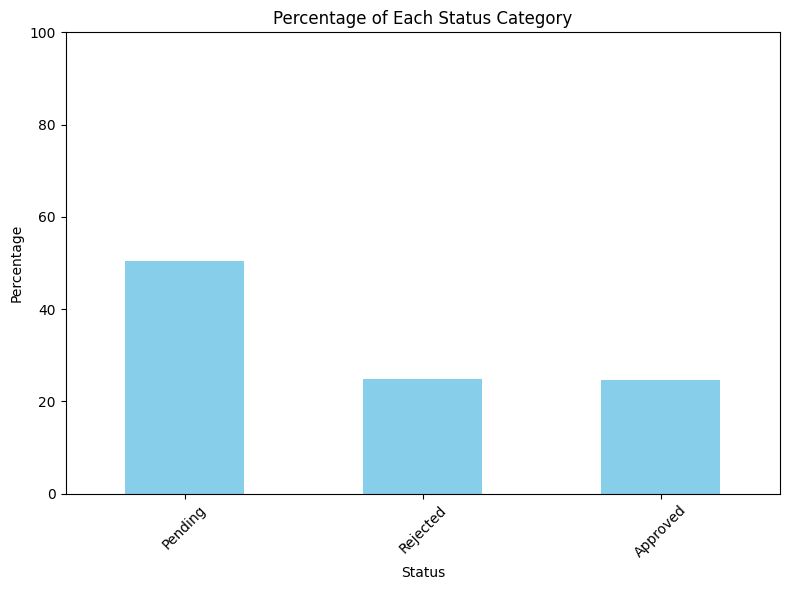

In [157]:


# Count occurrences of each status category
status_counts = projectDetails_df['STATUS'].value_counts()

# Calculate the total number of rows
total_rows = len(projectDetails_df)

# Calculate the percentage of each status category
status_percentage = (status_counts / total_rows) * 100

# Plot the bar plot
plt.figure(figsize=(8, 6))
status_percentage.plot(kind='bar', color='skyblue')
plt.xlabel('Status')
plt.ylabel('Percentage')
plt.title('Percentage of Each Status Category')
plt.xticks(rotation=45)
plt.ylim(0, 100)  # Set y-axis limit to ensure percentages are displayed properly
plt.tight_layout()
plt.show()


In [158]:
# Merge 'FIRST_NAME' and 'LAST_NAME' into 'FULL_NAME'
projectDetails_df['FULL_NAME'] = projectDetails_df['FIRST_NAME'] + ' ' + projectDetails_df['LAST_NAME']

# Drop 'FIRST_NAME' and 'LAST_NAME' columns
projectDetails_df.drop(['FIRST_NAME', 'LAST_NAME'], axis=1, inplace=True)

# Display the modified DataFrame

projectDetails_df = projectDetails_df[projectDetails_df['STATUS'] == 'Approved']

# Display the filtered data
projectDetails_df



,USER_PROJECT_ID,USER_ID,PROJECT_NAME,PROJECT_DESCRIPTION,STATUS,PROJECT_LINK,EMAIL,ROLE,PHONE_NUMBER,PASSWORD,CHANGE_PASSWORD,FULL_NAME
0,1,486,PixelNest,Developing a scalable web application using mi...,Approved,http://www.example.com/project35,whyldend7@trellian.com,user,2393348189,"pE1%MCFKIrUpT(~,",True,Waverly Hylden
1,2,215,CodeSavvy,Developing a decentralized autonomous liquidit...,Approved,http://www.example.com/project32,hveryard5o@answers.com,user,8124697873,eD9>*c5Qs7g?,True,Hatty Veryard
2,3,420,DataSphere,Building a decentralized finance (DeFi) platfo...,Approved,http://www.example.com/project89,asabybd@prnewswire.com,user,9699919427,nX4~{5FL+l,True,Anselm Saby
5,7,279,DataSphere,Implementing load balancing and auto-scaling f...,Approved,http://www.example.com/project51,sdanett7g@berkeley.edu,user,8543089518,zD8=kh&hlI,True,Saundra Danett
7,9,375,PixelGenius,Developing a peer-to-peer lending platform wit...,Approved,http://www.example.com/project7,rbrazeltona4@tumblr.com,user,3645306121,gN9`F~y@_V`,True,Raleigh Brazelton
...,...,...,...,...,...,...,...,...,...,...,...,...
800,882,227,DataBlast,Building a machine learning model for predicti...,Approved,http://www.example.com/project108,bprando60@nbcnews.com,user,7911994151,"zG7/aTdTUr""AY&$G",True,Bevon Prando
801,883,279,PixelNest,Developing a sentiment analysis tool for socia...,Approved,http://www.example.com/project83,sdanett7g@berkeley.edu,user,8543089518,zD8=kh&hlI,True,Saundra Danett
809,891,169,ByteGenius,Designing a decentralized content delivery net...,Approved,http://www.example.com/project17,mmccauley4e@nytimes.com,user,9281548370,"yJ2%A#X"",ky0Cp",True,Maximo McCauley
811,893,332,AppSphere,Developing a compliance management platform fo...,Approved,http://www.example.com/project38,rstather8x@google.es,user,8196014112,iS3+R0ZX)Ngte,True,Rodger Stather


In [159]:
projectDetails_df = projectDetails_df[['USER_ID','FULL_NAME','PROJECT_NAME', 'PROJECT_DESCRIPTION' ]]

In [160]:
certificateDetails_df

,USER_ID,FULL_NAME,CERTIFICATE_NAME
0,365,Terri Greatreax,AWS Certified Solutions Architect - Associate
2,73,Carly Bywaters,Google Professional Collaboration Engineer
3,216,Isis Shorie,Google Professional Cloud Network Engineer
5,454,Jonas Greed,Certified Cloud Security Professional (CCSP)
6,101,Belvia Blackborough,VMware Certified Associate - Digital Business ...
...,...,...,...
625,384,Vin Wahner,AWS Certified Security - Specialty
632,173,Celestina Rosenfeld,Certified ScrumMaster (CSM)
633,122,Chrisy Izkovitz,VMware Certified Design Expert (VCDX)
641,174,Marian Bettridge,VMware Certified Associate - Digital Business ...


In [161]:
skillsDetails_df

,USER_ID,FULL_NAME,SKILL_NAME,SKILL_LEVEL
0,169,Maximo McCauley,Kanban,Advance
1,158,Kania Haggus,Artificial Intelligence,Beginner
2,299,Taite Tipping,Java,Intermediate
6,362,Nigel Lewing,TypeScript,Beginner
7,149,Christiane Sharer,Vue.js,Beginner
...,...,...,...,...
743,68,Clem Latan,Jenkins,Beginner
744,424,Loydie Wych,HTML/CSS,Intermediate
745,509,Karen Seckington,Ruby on Rails,Intermediate
746,179,Swen Yarrington,Continuous Integration/Continuous Deployment (...,Intermediate


In [162]:
projectDetails_df

,USER_ID,FULL_NAME,PROJECT_NAME,PROJECT_DESCRIPTION
0,486,Waverly Hylden,PixelNest,Developing a scalable web application using mi...
1,215,Hatty Veryard,CodeSavvy,Developing a decentralized autonomous liquidit...
2,420,Anselm Saby,DataSphere,Building a decentralized finance (DeFi) platfo...
5,279,Saundra Danett,DataSphere,Implementing load balancing and auto-scaling f...
7,375,Raleigh Brazelton,PixelGenius,Developing a peer-to-peer lending platform wit...
...,...,...,...,...
800,227,Bevon Prando,DataBlast,Building a machine learning model for predicti...
801,279,Saundra Danett,PixelNest,Developing a sentiment analysis tool for socia...
809,169,Maximo McCauley,ByteGenius,Designing a decentralized content delivery net...
811,332,Rodger Stather,AppSphere,Developing a compliance management platform fo...


# Create a new text feature for nlp

In [163]:
projectDetails_df['text'] = projectDetails_df['PROJECT_NAME'] + ' ' + projectDetails_df['PROJECT_DESCRIPTION']

C:\Users\Swarna\AppData\Local\Temp\ipykernel_17668\4273326344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  projectDetails_df['text'] = projectDetails_df['PROJECT_NAME'] + ' ' + projectDetails_df['PROJECT_DESCRIPTION']


In [164]:
projectDetails_df

,USER_ID,FULL_NAME,PROJECT_NAME,PROJECT_DESCRIPTION,text
0,486,Waverly Hylden,PixelNest,Developing a scalable web application using mi...,PixelNest Developing a scalable web applicatio...
1,215,Hatty Veryard,CodeSavvy,Developing a decentralized autonomous liquidit...,CodeSavvy Developing a decentralized autonomou...
2,420,Anselm Saby,DataSphere,Building a decentralized finance (DeFi) platfo...,DataSphere Building a decentralized finance (D...
5,279,Saundra Danett,DataSphere,Implementing load balancing and auto-scaling f...,DataSphere Implementing load balancing and aut...
7,375,Raleigh Brazelton,PixelGenius,Developing a peer-to-peer lending platform wit...,PixelGenius Developing a peer-to-peer lending ...
...,...,...,...,...,...
800,227,Bevon Prando,DataBlast,Building a machine learning model for predicti...,DataBlast Building a machine learning model fo...
801,279,Saundra Danett,PixelNest,Developing a sentiment analysis tool for socia...,PixelNest Developing a sentiment analysis tool...
809,169,Maximo McCauley,ByteGenius,Designing a decentralized content delivery net...,ByteGenius Designing a decentralized content d...
811,332,Rodger Stather,AppSphere,Developing a compliance management platform fo...,AppSphere Developing a compliance management p...


In [165]:
skillsDetails_df['text'] = skillsDetails_df['SKILL_NAME'] + ' ' + skillsDetails_df['SKILL_LEVEL']


In [166]:
skillsDetails_df

,USER_ID,FULL_NAME,SKILL_NAME,SKILL_LEVEL,text
0,169,Maximo McCauley,Kanban,Advance,Kanban Advance
1,158,Kania Haggus,Artificial Intelligence,Beginner,Artificial Intelligence Beginner
2,299,Taite Tipping,Java,Intermediate,Java Intermediate
6,362,Nigel Lewing,TypeScript,Beginner,TypeScript Beginner
7,149,Christiane Sharer,Vue.js,Beginner,Vue.js Beginner
...,...,...,...,...,...
743,68,Clem Latan,Jenkins,Beginner,Jenkins Beginner
744,424,Loydie Wych,HTML/CSS,Intermediate,HTML/CSS Intermediate
745,509,Karen Seckington,Ruby on Rails,Intermediate,Ruby on Rails Intermediate
746,179,Swen Yarrington,Continuous Integration/Continuous Deployment (...,Intermediate,Continuous Integration/Continuous Deployment (...


In [167]:
projectDetails_df.shape , certificateDetails_df.shape , skillsDetails_df.shape

((274, 5), (198, 3), (300, 5))

In [168]:
project_columns = projectDetails_df.columns
certificate_columns = certificateDetails_df.columns
skills_columns = skillsDetails_df.columns

print("Columns for projectDetails_df:", project_columns)
print("Columns for certificateDetails_df:", certificate_columns)
print("Columns for skillsDetails_df:", skills_columns)


Columns for projectDetails_df: Index(['USER_ID', 'FULL_NAME', 'PROJECT_NAME', 'PROJECT_DESCRIPTION', 'text'], dtype='object')
Columns for certificateDetails_df: Index(['USER_ID', 'FULL_NAME', 'CERTIFICATE_NAME'], dtype='object')
Columns for skillsDetails_df: Index(['USER_ID', 'FULL_NAME', 'SKILL_NAME', 'SKILL_LEVEL', 'text'], dtype='object')


##  Merge three dataset into  ONE

In [169]:
m1 = pd.merge(skillsDetails_df[['USER_ID','FULL_NAME','text']],projectDetails_df[['USER_ID','text']],on="USER_ID",how="left")

In [170]:
m2 = pd.merge(m1,certificateDetails_df[['USER_ID','CERTIFICATE_NAME']],on='USER_ID',how='left')

In [171]:
m2.columns

Index(['USER_ID', 'FULL_NAME', 'text_x', 'text_y', 'CERTIFICATE_NAME'], dtype='object')

In [172]:
m2.rename(columns={'text_x':'skillsText','text_y':'projectText','CERTIFICATE_NAME':'certificateText'},inplace=True)

In [173]:
m2

,USER_ID,FULL_NAME,skillsText,projectText,certificateText
0,169,Maximo McCauley,Kanban Advance,CyberSphere Building a recommendation engine b...,NaN
1,169,Maximo McCauley,Kanban Advance,DataBlast Designing a decentralized social med...,NaN
2,169,Maximo McCauley,Kanban Advance,ByteGenius Designing a decentralized content d...,NaN
3,158,Kania Haggus,Artificial Intelligence Beginner,CodeCraft Building a blockchain-based decentra...,Microsoft Certified: Azure Fundamentals
4,158,Kania Haggus,Artificial Intelligence Beginner,CodeCraft Building a blockchain-based decentra...,Google Professional Cloud Network Engineer
...,...,...,...,...,...
735,424,Loydie Wych,HTML/CSS Intermediate,NaN,NaN
736,509,Karen Seckington,Ruby on Rails Intermediate,NaN,NaN
737,179,Swen Yarrington,Continuous Integration/Continuous Deployment (...,CodeNest Building a collaborative project mana...,Google Professional Data Engineer
738,254,Hinze Teresi,Kotlin Intermediate,CodeCraft Designing a decentralized finance (D...,NaN


## now marge all three text into a one

In [174]:
m2.fillna(' ',inplace=True)

In [175]:
m2['text'] = m2['projectText'] + ' ' + m2['certificateText']+ ' ' + m2['skillsText']

In [176]:
m2

,USER_ID,FULL_NAME,skillsText,projectText,certificateText,text
0,169,Maximo McCauley,Kanban Advance,CyberSphere Building a recommendation engine b...,,CyberSphere Building a recommendation engine b...
1,169,Maximo McCauley,Kanban Advance,DataBlast Designing a decentralized social med...,,DataBlast Designing a decentralized social med...
2,169,Maximo McCauley,Kanban Advance,ByteGenius Designing a decentralized content d...,,ByteGenius Designing a decentralized content d...
3,158,Kania Haggus,Artificial Intelligence Beginner,CodeCraft Building a blockchain-based decentra...,Microsoft Certified: Azure Fundamentals,CodeCraft Building a blockchain-based decentra...
4,158,Kania Haggus,Artificial Intelligence Beginner,CodeCraft Building a blockchain-based decentra...,Google Professional Cloud Network Engineer,CodeCraft Building a blockchain-based decentra...
...,...,...,...,...,...,...
735,424,Loydie Wych,HTML/CSS Intermediate,,,HTML/CSS Intermediate
736,509,Karen Seckington,Ruby on Rails Intermediate,,,Ruby on Rails Intermediate
737,179,Swen Yarrington,Continuous Integration/Continuous Deployment (...,CodeNest Building a collaborative project mana...,Google Professional Data Engineer,CodeNest Building a collaborative project mana...
738,254,Hinze Teresi,Kotlin Intermediate,CodeCraft Designing a decentralized finance (D...,,CodeCraft Designing a decentralized finance (D...


In [177]:
final_data = m2[['USER_ID','FULL_NAME','text']]
final_data

,USER_ID,FULL_NAME,text
0,169,Maximo McCauley,CyberSphere Building a recommendation engine b...
1,169,Maximo McCauley,DataBlast Designing a decentralized social med...
2,169,Maximo McCauley,ByteGenius Designing a decentralized content d...
3,158,Kania Haggus,CodeCraft Building a blockchain-based decentra...
4,158,Kania Haggus,CodeCraft Building a blockchain-based decentra...
...,...,...,...
735,424,Loydie Wych,HTML/CSS Intermediate
736,509,Karen Seckington,Ruby on Rails Intermediate
737,179,Swen Yarrington,CodeNest Building a collaborative project mana...
738,254,Hinze Teresi,CodeCraft Designing a decentralized finance (D...


In [ ]:
final_data.to_csv('ML_Data_Ready.csv',index=None)